## 准备数据

In [36]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

def target_fun(x):
    # 目标函数为1-x/1+x
    return -2/(2+np.sin(x)) + 0.01*np.random.rand(x.size).reshape(-1, 1)

def generate_dataset():
    # 生成数据集
    x_train = np.linspace(-3, 3, 2000).reshape(-1, 1)
    y_train = target_fun(x_train)
    x_test = np.linspace(-3, 3, 333).reshape(-1, 1)
    y_test = target_fun(x_test)
    return (x_train,y_train),(x_test,y_test)
    

## Demo numpy based auto differentiation

In [37]:
import numpy as np

class Matmul:
    def __init__(self):
        self.mem = {}
        
    def forward(self, x, W):
        h = np.matmul(x, W)
        self.mem={'x': x, 'W':W}
        return h
    
    def backward(self, grad_y):
        '''
        x: shape(N, d)
        w: shape(d, d')
        grad_y: shape(N, d')
        '''
        # y = w*x
        # grad_y = dL/dy
        # grad_x = dL/dx = dL/dy * dy/dx = grad_y*w.T
        # grad_W = dL/dw = dL/dy * dy/dw = x.T*grad_y
        x = self.mem['x']
        W = self.mem['W']
        
        ####################
        '''计算矩阵乘法的对应的梯度'''
        ####################
        grad_x = np.matmul(grad_y, W.T)
        grad_W = np.matmul(x.T,grad_y)
        
        return grad_x, grad_W


class Relu:
    def __init__(self):
        self.mem = {}
        
    def forward(self, x):
        self.mem['x']=x
        return np.where(x > 0, x, np.zeros_like(x))
    
    def backward(self, grad_y):
        '''
        grad_y: same shape as x
        '''
        ####################
        '''计算relu 激活函数对应的梯度'''
        ####################
        # y = max(0,x)
        # grad_x = dL/dy * dy/dx = grad_y*0/1
        x = self.mem['x']
        grad_x = (x>0).astype(np.float32) * grad_y # x是Array用三元表达式不方便
        return grad_x
    


class Softmax:
    '''
    softmax over last dimention
    '''
    def __init__(self):
        self.epsilon = 1e-12
        self.mem = {}
        
    def forward(self, x):
        '''
        x: shape(N, c)
        '''
        x_exp = np.exp(x)
        partition = np.sum(x_exp, axis=1, keepdims=True)
        out = x_exp/(partition+self.epsilon)
        
        self.mem['out'] = out
        self.mem['x_exp'] = x_exp
        return out
    
    def backward(self, grad_y):
        '''
        grad_y: same shape as x
        '''
        s = self.mem['out']
        sisj = np.matmul(np.expand_dims(s,axis=2), np.expand_dims(s, axis=1)) # (N, c, c)
        g_y_exp = np.expand_dims(grad_y, axis=1)
        tmp = np.matmul(g_y_exp, sisj) #(N, 1, c)
        tmp = np.squeeze(tmp, axis=1)
        tmp = -tmp+grad_y*s 
        return tmp
    
class Log:
    '''
    softmax over last dimention
    '''
    def __init__(self):
        self.epsilon = 1e-12
        self.mem = {}
        
    def forward(self, x):
        '''
        x: shape(N, c)
        '''
        out = np.log(x+self.epsilon)
        
        self.mem['x'] = x
        return out
    
    def backward(self, grad_y):
        '''
        grad_y: same shape as x
        '''
        x = self.mem['x']
        
        return 1./(x+1e-12) * grad_y
    


## 建立模型

In [38]:
class myModel:
    def __init__(self):
        
        self.W1 = np.random.normal(size=[1+1, 800])*0.1
        self.W2 = np.random.normal(size=[800, 1])*0.1
        
        self.mul_h1 = Matmul()
        self.mul_h2 = Matmul()
        self.relu = Relu()
        
    def forward(self, x):
        x = x.reshape(-1, 1)
        bias = np.ones(shape=[x.shape[0], 1])
        x = np.concatenate([x, bias], axis=1)
        self.h1 = self.mul_h1.forward(x, self.W1)
        self.h1_relu = self.relu.forward(self.h1)
        self.h2 = self.mul_h2.forward(self.h1_relu, self.W2)
            
    def backward(self, preds, y):
        self.h2_grad, self.W2_grad = self.mul_h2.backward(2*(preds-y)/y.shape[0])
        self.h1_relu_grad = self.relu.backward(self.h2_grad)
        self.h1_grad, self.W1_grad = self.mul_h1.backward(self.h1_relu_grad)
        
model = myModel()


## 计算 loss

In [39]:
def compute_loss(preds, y):
    return np.mean(np.square(y-preds))
    
def compute_accuracy(preds, y):
    return np.mean((np.abs(y-preds)/np.abs(y))<0.1)

def train_one_step(model, x, y):
    model.forward(x)
    model.backward(model.h2,y)
    model.W1 -= 1e-1* model.W1_grad
    model.W2 -= 1e-1* model.W2_grad
    loss = compute_loss(model.h2, y)
    accuracy = compute_accuracy(model.h2, y)
    return loss, accuracy

def test(model, x, y):
    model.forward(x)
    loss = compute_loss(model.h2, y)
    accuracy = compute_accuracy(model.h2, y)
    return model.h2,loss, accuracy

## 实际训练

In [40]:
(train_x,train_y),(test_x,test_y) = generate_dataset()
for epoch in range(500):
    loss, accuracy = train_one_step(model, train_x , train_y)
    print('epoch', epoch, ': loss', loss, '; accuracy', accuracy)
preds, loss, accuracy = test(model,test_x , test_y)

print('test loss', loss, '; accuracy', accuracy)

epoch 0 : loss 1.6385433253492014 ; accuracy 0.0
epoch 1 : loss 5.693898157250888 ; accuracy 0.0
epoch 2 : loss 12.974452090237842 ; accuracy 0.0
epoch 3 : loss 3.8724595050697306 ; accuracy 0.0
epoch 4 : loss 6.124206830179212 ; accuracy 0.042
epoch 5 : loss 2.824619568456127 ; accuracy 0.097
epoch 6 : loss 0.2797737747127178 ; accuracy 0.0415
epoch 7 : loss 0.1426648074931657 ; accuracy 0.045
epoch 8 : loss 0.12064335943998034 ; accuracy 0.4745
epoch 9 : loss 0.1106381598887889 ; accuracy 0.4875
epoch 10 : loss 0.1027573676349489 ; accuracy 0.496
epoch 11 : loss 0.0964364945911856 ; accuracy 0.4945
epoch 12 : loss 0.09109839865196882 ; accuracy 0.4455
epoch 13 : loss 0.08658752442063945 ; accuracy 0.4275
epoch 14 : loss 0.08287005149604841 ; accuracy 0.4235
epoch 15 : loss 0.07979105502618868 ; accuracy 0.414
epoch 16 : loss 0.07707129940995079 ; accuracy 0.4065
epoch 17 : loss 0.07461194612539374 ; accuracy 0.4025
epoch 18 : loss 0.07235947696145918 ; accuracy 0.396
epoch 19 : loss 

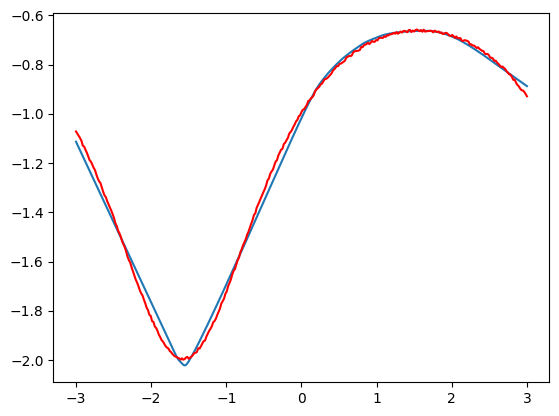

In [41]:
import matplotlib.pyplot as plt

plt.plot(test_x.flatten(),preds.flatten())
plt.plot(test_x.flatten(),test_y.flatten(),color='red')